In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

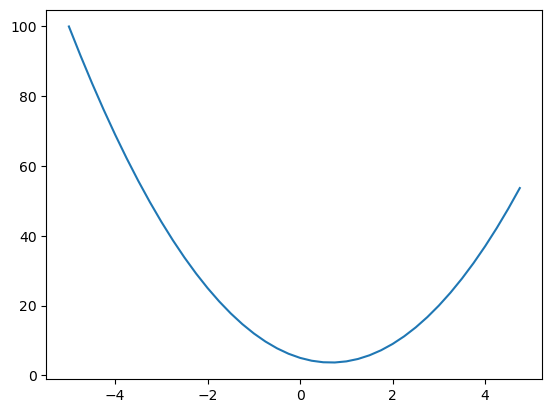

In [5]:
plt.plot(xs, ys)

In [6]:
# compute the derivative of f by the definition of rate of change
h = 0.000001
x = 3.0
slope = (f(x + h) - f(x)) / h # numerical approximation of the function slope at x
slope

14.000003002223593

In [7]:
# a more complex function
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [8]:
h = 0.0001

d1 = a * b + c
a += h
d2 = a * b + c

print(f'{d1}')
print(f'{d2}')
print(f'slope: {(d2 - d1) / h}') # it should just give you b

4.0
3.999699999999999
slope: -3.000000000010772


In [9]:
h = 0.0001

d1 = a * b + c
c += h
d2 = a * b + c

print(f'{d1}')
print(f'{d2}')
print(f'slope: {(d2 - d1) / h}') # it should just give you b

3.999699999999999
3.9997999999999987
slope: 0.9999999999976694


## Let's Start to Build a Neural Network

In [65]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self._grad = 0.
        self._prev = set(_children)
        self._op = _op
        self._label = label
    
    def __repr__(self):
        # internal function to return the string representation of the object
        return f'Value(data={self._data})'
    
    def __add__(self, other):
        out = Value(self._data + other._data, (self, other), '+')
        
        return out

    def __mul__(self, other):
        out = Value(self._data * other._data, (self, other), '*')
        
        return out
        
    def tanh(self):
        x = self._data
        
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        
        out = Value(t, (self,), 'tanh')
        
        return out

In [66]:
a = Value(2.0, label='a')
print(a)

Value(data=2.0)


In [67]:
b = Value(-3.0, label='b')

In [68]:
e = a * b; e._label = 'e'

In [69]:
c = Value(10.0, label='c')

In [70]:
print(a * b + c)

Value(data=4.0)


In [71]:
print((a.__mul__(b)).__add__(c))

Value(data=4.0)


In [72]:
d = e + c; d._label = 'd'

In [73]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [74]:
d._op

'+'

In [75]:
from graphviz import Digraph

def trace(root):
    # build a graph of all the nodes and edges starting from the root
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root):
    # render the graph in dot format
    dot = Digraph(format('svg'),
                  graph_attr={'rankdir': 'LR',
                              'bgcolor': '#272822'}, # LR = left to right
                  node_attr={'style': 'filled',
                             'fillcolor': '#2e2e2e',
                             'textcolor': 'white',
                             'fontcolor': 'white',
                             'fontname': 'monospace',
                             'fontsize': '11',
                             'color': 'white'},
                  edge_attr={'color': 'white'})
    
    nodes, edges = trace(root)
    
    for node in nodes:
        uid = str(id(node))
        # for any value in the graph, create a <code>record</code> node (rectangular shape) for it
        dot.node(name=uid, label=f'{ node._label} | data: {node._data: .4f} | grad: {node._grad: .4f} ', shape='record')
        
        if node._op:
            # if the value is a result of some operations, create an op node for it
            dot.node(name=uid + node._op, label=node._op)
            # connect this _op node to the value node
            dot.edge(uid + node._op, uid)
    
    for src, dst in edges:
        # connect the source value node to the op node of the destination value node
        dot.edge(str(id(src)), str(id(dst)) + dst._op)
    
    return dot

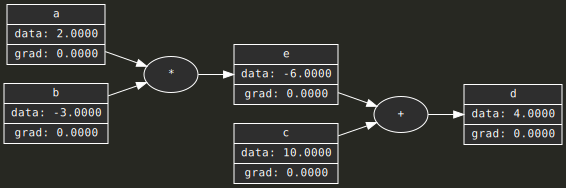

In [76]:
draw_dot(d)

In [77]:
f = Value(-2.0, label='f')
L = d * f; L._label = 'L'
L

Value(data=-8.0)

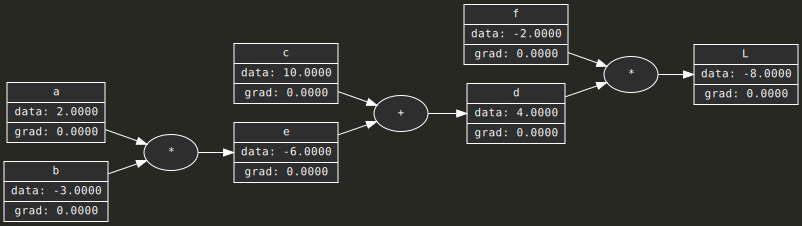

In [78]:
draw_dot(L)

## Backpropagation

In [79]:
L._grad = 1.0

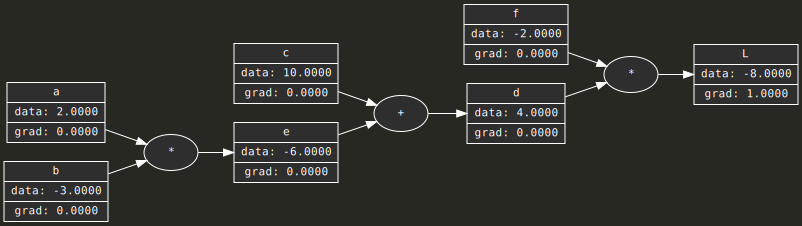

In [80]:
draw_dot(L)

In [81]:
f._grad = 4.0 # dL/df = d(d * f)/df = d
d._grad = -2.0 # dL/dd = d(d * f)/dd = f

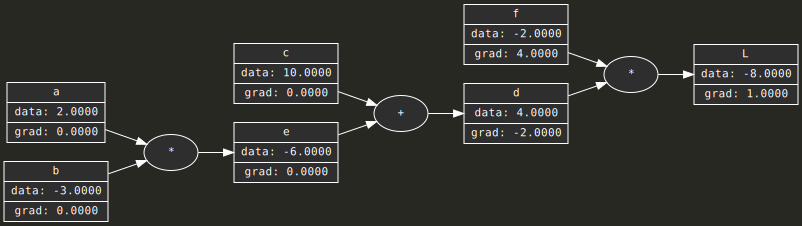

In [82]:
draw_dot(L)

In [83]:
c._grad = -2.0 # chain rule, dL/dc = dL/dd * dd/dc = -2 * 1
e._grad = -2.0 # chain rule, dL/de = dL/dd * dd/de = -2 * 1

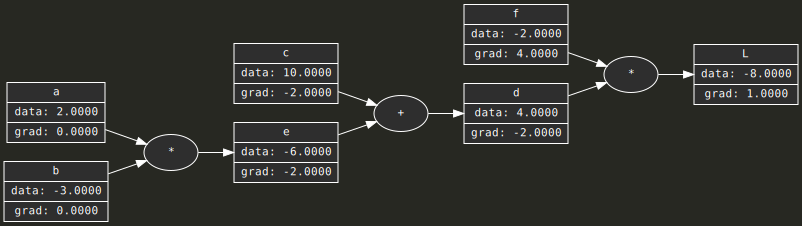

In [84]:
draw_dot(L)

We can see that by chain rule, the plus operation essentially provides a rerouting of the gradients!

In [85]:
a._grad = 6.0 # chain rule, dL/da = dL/de * de/da = (-2) * (-3)
b._grad = -4.0 # chain rule, dL/db = dL/de * de/db = (-2) * 2

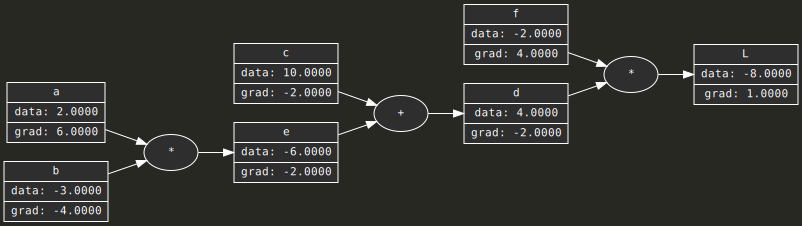

In [86]:
draw_dot(L)

## Let's Build a Neural Network

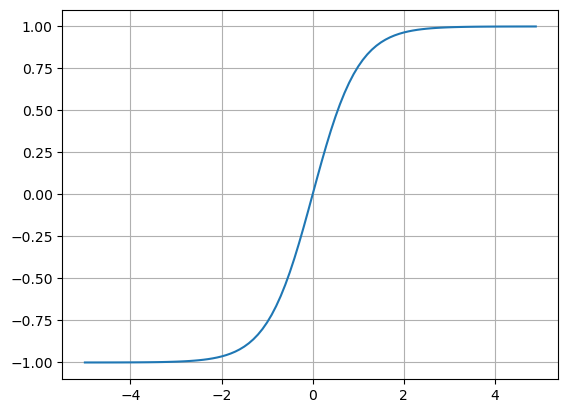

In [87]:
# visualize the tanh function
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1))); plt.grid(); plt.show()

### Let's build a neuron

In [88]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.7, label='b')

# linear combination: x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

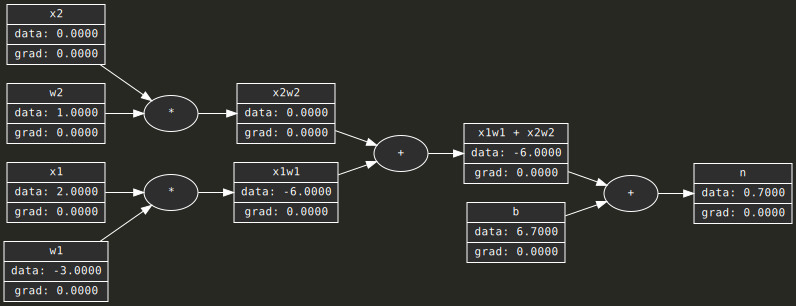

In [89]:
draw_dot(n)

In [90]:
# let's add the tanh activation function
o = n.tanh(); o._label = 'o'

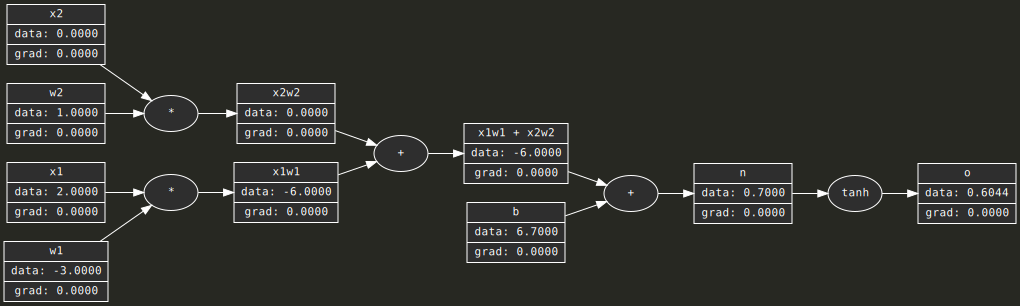

In [91]:
draw_dot(o)